In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import pandas as pd
from time import time
from glob import glob
from PIL import Image
from typing import List, Union
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback

from model import SegmentationModel

In [3]:
PROJECT="CamVid"
ENTITY="av-demo"
IMAGE_SHAPE = (720, 960)
SEED = 123
RUN_NAME = "baseline-train-2"
JOB_TYPE = "baseline-train"

In [4]:
set_seed(SEED)

## DataLoader for SegmentationDataLoader for Segmentation

In [5]:
def label_func(fn):
    return fn.parent.parent/"labels"/f"{fn.stem}_P{fn.suffix}"


def get_dataloader(artifact_id: str, batch_size: int = 8, resize_factor: int = 4, validation_split: float = 0.2, seed=None):
    """Grab an artifact and creating a Pytorch DataLoader"""
    artifact = wandb.use_artifact(artifact_id, type='dataset')
    artifact_dir = Path(artifact.download())
    codes = np.loadtxt(artifact_dir/'codes.txt', dtype=str)
    fnames = get_image_files(artifact_dir/"images")
    class_labels = {k: v for k, v in enumerate(codes)}
    return SegmentationDataLoaders.from_label_func(
        artifact_dir,
        bs=batch_size,
        fnames=fnames,
        label_func=label_func,
        codes=codes,
        item_tfms=Resize((
            IMAGE_SHAPE[0] // resize_factor,
            IMAGE_SHAPE[1] // resize_factor
        )),
        valid_pct=validation_split,
        seed=seed
    ), class_labels

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: av-demo (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact camvid-dataset:v0, 1456.69MB. 1422 files... Done. 0:0:0


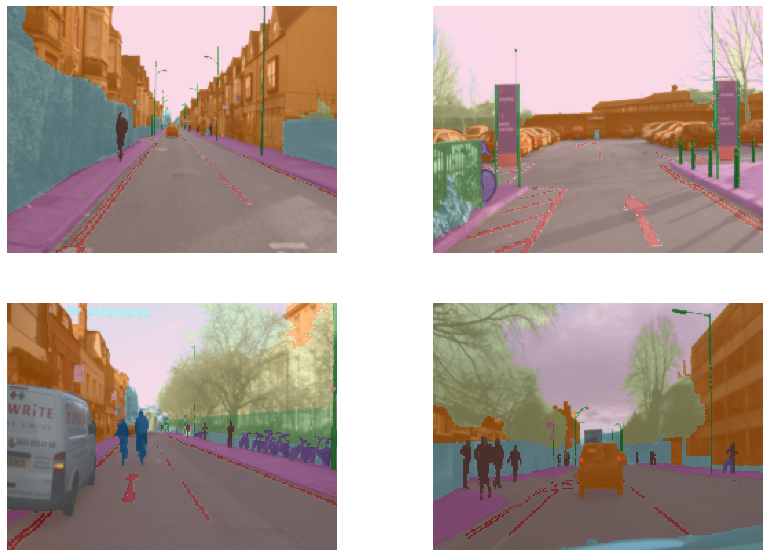

In [6]:
run = wandb.init(
    project=PROJECT,
    name=RUN_NAME,
    entity=ENTITY,
    job_type=JOB_TYPE
)

data_loader, class_labels = get_dataloader(
    artifact_id="av-demo/CamVid/camvid-dataset:v0",
    batch_size=16,
    resize_factor=4,
    validation_split=0.2,
    seed=SEED
)

data_loader.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

## Training and Inference

In [7]:
def get_model_parameters(model):
    with torch.no_grad():
        num_params = sum(p.numel() for p in model.parameters())
    return num_params


def get_predictions(learner):
    inputs, predictions, targets, outputs = learner.get_preds(with_input=True, with_decoded=True)
    x, y, samples, outputs = learner.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=36
    )
    return samples, outputs, predictions


def benchmark_inference_time(model, batch_size: int, num_iter: int):
    data_loader, class_labels = get_dataloader(
        artifact_id="av-demo/CamVid/camvid-dataset:v0",
        batch_size=batch_size,
        resize_factor=1,
        validation_split=0.2,
        seed=SEED
    )
    inference_time = 0
    print(f"Computing inference time over {num_iter} iterations with batches of {batch_size} images...")
    with torch.no_grad():
        for _ in tqdm(range(num_iter)):
            x, y = next(iter(data_loader.valid))
            start_time = time.time()
            y_pred = model(x)
            inference_time += (time.time() - start_time)
    return inference_time / (num_iter * batch_size)


def create_wandb_table(samples, outputs, predictions, class_labels):
    "Creates a wandb table with predictions and targets side by side"
    table = wandb.Table(columns=["Image", "Predicted Mask", "Ground Truth"])
    for (image, label), pred_label in zip(samples, outputs):
        image = image.permute(1, 2, 0)
        table.add_data(
            wandb.Image(image),
            wandb.Image(
                image,
                masks={
                    "predictions":  {
                        'mask_data':  pred_label[0].numpy(),
                        'class_labels':class_labels
                    }
                }
            ),
            wandb.Image(
                image,
                masks={
                    "ground truths": {
                        'mask_data': label.numpy(),
                        'class_labels':class_labels
                    }
                }
            )
        )
    return table

In [8]:
def get_learner(
    data_loader,
    backbone: str,
    hidden_dim: int,
    num_classes: int,
    checkpoint_file: Union[None, str, Path],
    loss_func,
    metrics: List,
    log_preds: bool = False
):
    model = SegmentationModel(backbone, hidden_dim, num_classes=num_classes)
    save_model_callback = SaveModelCallback(fname=f"unet_{backbone}")
    mixed_precision_callback = MixedPrecision()
    wandb_callback = WandbCallback(log_preds=True)
    learner = Learner(
        data_loader,
        model,
        loss_func=loss_func,
        metrics=metrics,
        cbs=[save_model_callback, mixed_precision_callback, wandb_callback]
    )
    if checkpoint_file is not None:
        learner.load(checkpoint_file)
    return learner

In [9]:
learner = get_learner(
    data_loader,
    backbone="mobilenetv2_100",
    hidden_dim=256,
    num_classes=len(class_labels),
    checkpoint_file=None,
    # loss_func=FocalLossFlat(axis=1),
    loss_func=DiceLoss(axis=1),
    metrics=[DiceMulti(), foreground_acc],
    log_preds=True
)

In [10]:
# learner.fine_tune(10, 1e-3)
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,491.322998,461.371582,0.123942,0.681894,00:18
1,461.898224,436.262360,0.186619,0.736451,00:12
2,434.734192,409.305511,0.263505,0.824266,00:12
3,414.002899,397.673981,0.315609,0.772933,00:12
4,397.023621,385.154846,0.351125,0.831888,00:12
5,383.106781,380.735596,0.367829,0.814191,00:12
6,371.908234,368.328979,0.409103,0.864221,00:12
7,363.711121,360.896545,0.431909,0.871552,00:12
8,357.697235,360.385406,0.436238,0.874420,00:12
9,354.008789,359.102722,0.440010,0.874724,00:12


Better model found at epoch 0 with valid_loss value: 461.37158203125.
Better model found at epoch 1 with valid_loss value: 436.2623596191406.
Better model found at epoch 2 with valid_loss value: 409.3055114746094.
Better model found at epoch 3 with valid_loss value: 397.6739807128906.
Better model found at epoch 4 with valid_loss value: 385.15484619140625.
Better model found at epoch 5 with valid_loss value: 380.735595703125.
Better model found at epoch 6 with valid_loss value: 368.3289794921875.
Better model found at epoch 7 with valid_loss value: 360.89654541015625.
Better model found at epoch 8 with valid_loss value: 360.3854064941406.
Better model found at epoch 9 with valid_loss value: 359.10272216796875.


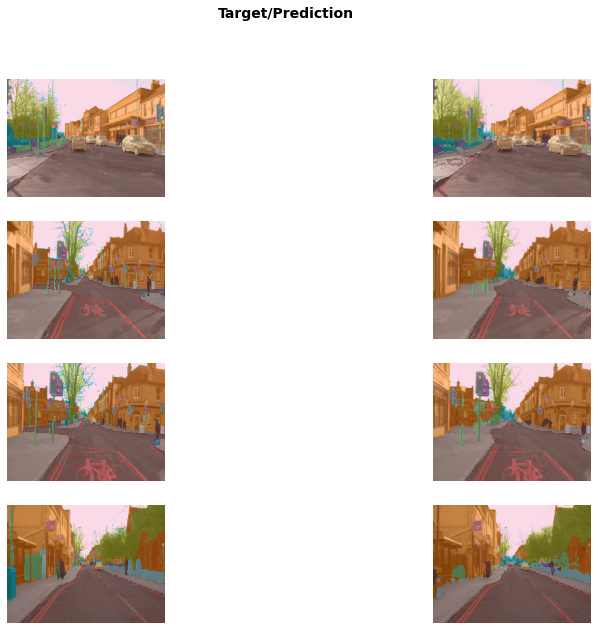

In [11]:
learner.show_results(max_n=4, figsize=(14, 10))

In [12]:
samples, outputs, predictions = get_predictions(learner)
table = create_wandb_table(samples, outputs, predictions, class_labels)
wandb.log({f"Baseline_Predictions_{run.name}": table})

In [13]:
model = learner.model.eval()
torch.cuda.empty_cache()
wandb.log({"Model_Parameters": get_model_parameters(model)})
wandb.log({"Inference_Time": benchmark_inference_time(model, batch_size=8, num_iter=20)})

wandb: Downloading large artifact camvid-dataset:v0, 1456.69MB. 1422 files... Done. 0:0:0


Computing inference time over 20 iterations with batches of 8 images...


  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
run.finish()

Inference_Time,▁
Model_Parameters,▁
dice_multi,▁▂▄▅▆▆▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
foreground_acc,▁▃▆▄▆▆████
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▆▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,███▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▁▂▁▁▂▁▁▂▂▂▂▁▂▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,████▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
